In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from models.unet.unet import UNet
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.data_management.data_loader import DataLoaderManager

import cv2

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Load the data to split it and save it to a dict
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/patchify_4_classes/"))

In [3]:
unet = UNet(num_classes=4, experiment_name="test_experiments", use_mlflow=False)

In [4]:
# Load the data to the model
data = unet.load_data(path, CNNFormes)

Not classified percentage: 42.260%

Land percentage: 31.173%

Sea percentage: 26.415%

Shoreline percentage: 0.153%

---

not_classified = 42,260 / 42,260 =  1

land = 42,260 / 31,173 = 1,36

sea = 142,260 / 26,415 = 1,60

shoreline = 42,260 / 0,153 = 276,14


In [5]:
weight = [1, 1.36, 1.60, 276.14]

artifact_path = os.path.abspath(os.path.join(path, "../../artifacts/"))

# Train the model
# unet.train(epochs=50, loss_function_name="BCEWithLogitsLoss", weight=weight, artifact_path=artifact_path)

# Predictions

/srv/Shoreline-extraction/data/patchify_4_classes/test/images/1525622460.Sun.May.06_17_01_00.CET.2018.cies.image.patch.0_1.jpg
/srv/Shoreline-extraction/data/patchify_4_classes/test/masks/1525622460.Sun.May.06_17_01_00.CET.2018.cies.mask.patch.0_1.png
(array([0, 1, 2, 3], dtype=uint8), array([24136, 14520, 26539,   341]))
(array([0, 1, 2, 3]), array([24111, 14421, 26665,   339]))


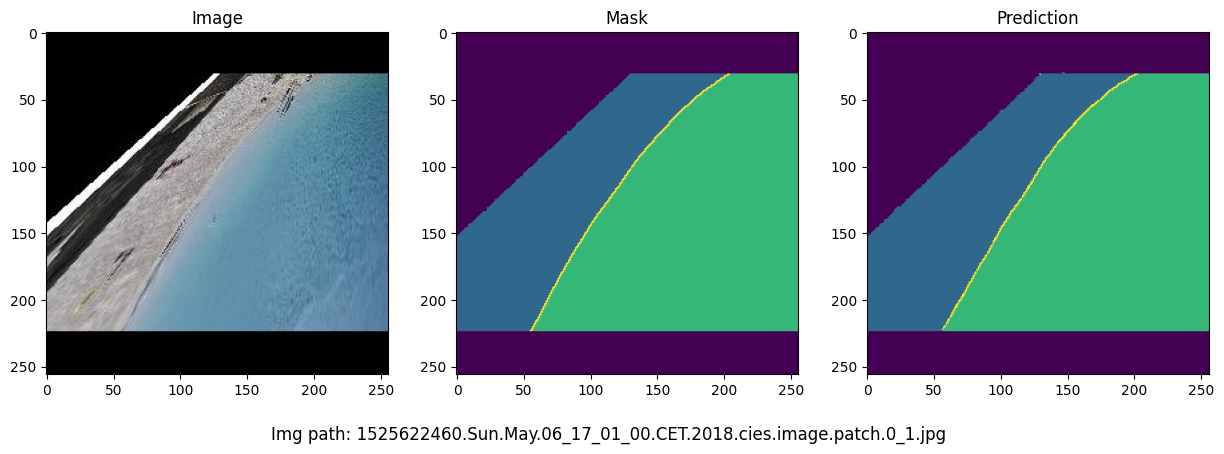

In [15]:
# Predict one patch
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/patchify_4_classes/"))

data = DataLoaderManager.load_data(data_path)
index = 0 # 72
img_path = data["test"]['images'][index]
img_path = "/srv/Shoreline-extraction/data/patchify_4_classes/test/images/1525622460.Sun.May.06_17_01_00.CET.2018.cies.image.patch.0_1.jpg"
mask_path = data["test"]['masks'][index]
mask_path = "/srv/Shoreline-extraction/data/patchify_4_classes/test/masks/1525622460.Sun.May.06_17_01_00.CET.2018.cies.mask.patch.0_1.png"
print(img_path)
print(mask_path)

unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# pred = unet.predict(img)
pred = unet.predict(img_path)

print(np.unique(mask, return_counts=True))
print(np.unique(pred.cpu(), return_counts=True))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Img path: {img_path.split('/')[-1]}", y=0.05)

ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

ax[2].imshow(pred.cpu().squeeze())
ax[2].set_title("Prediction")

plt.show()

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
/srv/Shoreline-extraction/data/processed_4_classes/images/1603883400.Wed.Oct.28_12_10_00.CET.2020.agrelo.image.jpg
/srv/Shoreline-extraction/data/processed_4_classes/masks/1603883400.Wed.Oct.28_12_10_00.CET.2020.agrelo.mask.png
(array([0, 1, 2, 3], dtype=uint8), array([ 46913, 163169,  90356,    885]))
(array([0, 1, 2, 3]), array([ 46841, 163034,  90980,    468]))


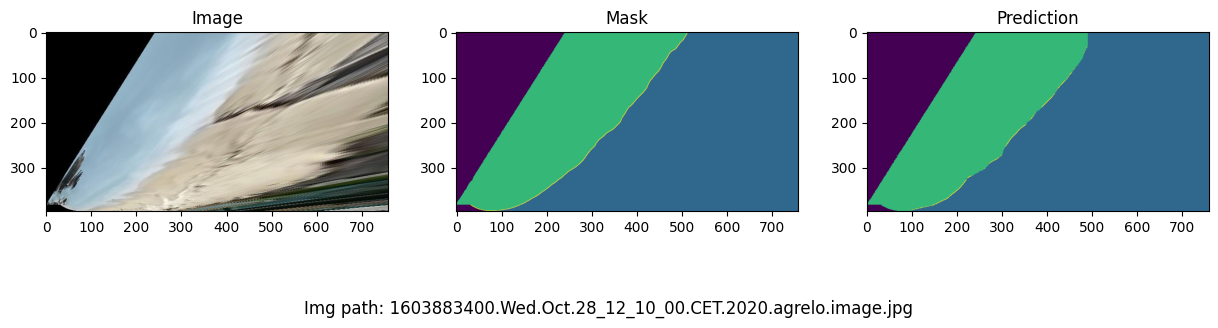

In [22]:
# Predict the full image
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)
index = 1 # 25 # 72
img_path = data["test"]['images'][index]
#img_path = "/srv/Shoreline-extraction/data/processed_4_classes/images/1525622460.Sun.May.06_17_01_00.CET.2018.cies.image.jpg"
print(img_path)
mask_path = data["test"]['masks'][index]
print(mask_path)
#mask_path = "/srv/Shoreline-extraction/data/processed_4_classes/masks/1525622460.Sun.May.06_17_01_00.CET.2018.cies.mask.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

pred = unet.predict_patch(img_path, combination="max")

print(np.unique(mask, return_counts=True))
print(np.unique(pred, return_counts=True))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Img path: {img_path.split('/')[-1]}", y=0.05)

ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

ax[2].imshow(pred.squeeze())
ax[2].set_title("Prediction")

plt.show()

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
(array([0, 1, 2, 3], dtype=uint8), array([194744, 155727, 213667,   1022]))
(array([0, 1, 2, 3]), array([193871, 153969, 216995,    325]))


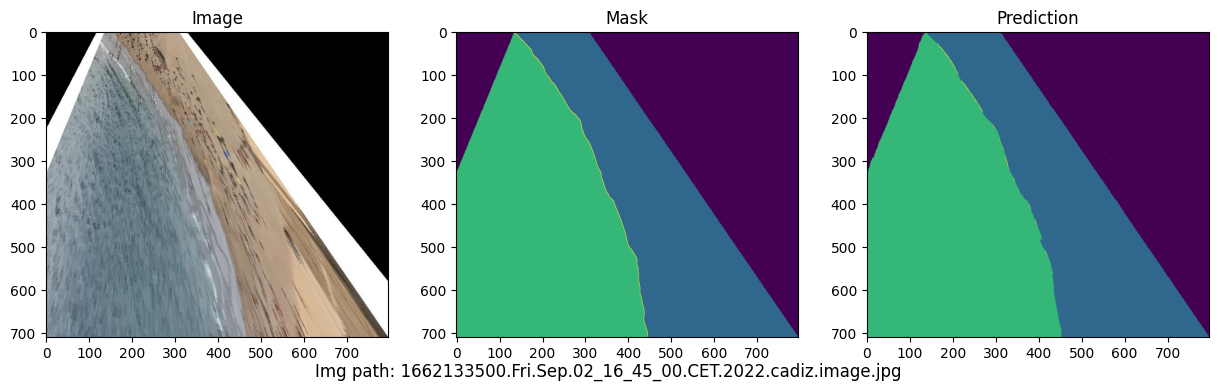

In [7]:
# Predict the full image
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)
index = 100 # 25 # 72
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

pred = unet.predict_patch(img_path, combination="max")

print(np.unique(mask, return_counts=True))
print(np.unique(pred, return_counts=True))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Img path: {img_path.split('/')[-1]}", y=0.05)

ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

ax[2].imshow(pred.squeeze())
ax[2].set_title("Prediction")

plt.show()

# Metrics

In [10]:
from src.models.metrics import Metrics

artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 4
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, compute_loss=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, compute_loss=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, compute_loss=False)
}

# Load the data to split it and save it to a dict
unet = UNet(num_classes=num_classes, experiment_name="test_experiments", use_mlflow=False)
unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        print(img_path)
        pred = unet.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(mask, pred)
        break

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
Split: train
/srv/Shoreline-extraction/data/processed_4_classes/images/1555342200.Mon.Apr.15_16_30_00.CET.2019.agrelo.image.jpg
train metrics: 
	train_accuracy: tensor([0.9988, 0.9990, 0.9978, 0.7469])
	train_f1_score: tensor([0.9988, 0.9993, 0.9977, 0.6991])
	train_precision: tensor([0.9988, 0.9997, 0.9976, 0.6570])
	train_recall: tensor([0.9988, 0.9990, 0.9978, 0.7469])
	train_confusion_matrix: 
		0.9988 0.0000 0.0012 0.0000
		0.0000 0.9990 0.0000 0.0010
		0.0008 0.0000 0.9978 0.0014
		0.0000 0.0766 0.1765 0.7469

Split: validation
/srv/Shoreline-extraction/data/processed_4_classes/images/1558081200.Fri.May.17_09_20_00.CET.2019.agrelo.image.jpg
val metrics: 
	val_accuracy: tensor([0.9998, 0.9930, 0.9713, 0.0976])
	val_f1_score: tensor([0.9995, 0.9921, 0.9778, 0.0404])
	val_precision: tensor([0.99

## Metrics with margin

In [9]:
from src.models.metrics import Metrics

artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 4
margin = 10
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=True, margin = margin)
}

# Load the data to split it and save it to a dict
unet = UNet(num_classes=num_classes, experiment_name="test_experiments", use_mlflow=False)
unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        print(img_path)
        pred = unet.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)
        break

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
Split: train
/srv/Shoreline-extraction/data/processed_4_classes/images/1555342200.Mon.Apr.15_16_30_00.CET.2019.agrelo.image.jpg
torch.Size([409, 761])
torch.Size([8620])
train metrics: 
	train_accuracy: tensor([0.9310, 0.9842, 0.9684, 0.6570])
	train_f1_score: tensor([0.9643, 0.9686, 0.9703, 0.6991])
	train_precision: tensor([1.0000, 0.9536, 0.9722, 0.7469])
	train_recall: tensor([0.9310, 0.9842, 0.9684, 0.6570])
	train_confusion_matrix: 
		0.9310 0.0000 0.0690 0.0000
		0.0000 0.9842 0.0005 0.0153
		0.0000 0.0000 0.9684 0.0316
		0.0000 0.2118 0.1312 0.6570

Split: validation
/srv/Shoreline-extraction/data/processed_4_classes/images/1558081200.Fri.May.17_09_20_00.CET.2019.agrelo.image.jpg
torch.Size([412, 745])
torch.Size([8614])
val metrics: 
	val_accuracy: tensor([1.0000, 0.6088, 0.7810, 0.0254])


In [6]:
from src.models.metrics import Metrics

artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 4
margin = 10
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=True, margin = margin)
}

# Load the data to split it and save it to a dict
unet = UNet(num_classes=num_classes, experiment_name="test_experiments", use_mlflow=False)
unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

for split in data:
    print(f"Split: {split}")
    if (split == "train" or split == "validation"):
        continue
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = unet.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
Split: train
Split: validation
Split: test


/opt/conda/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


test metrics: 
	test_accuracy: tensor([0.9298, 0.7698, 0.6688, 0.0688])
	test_f1_score: tensor([0.9600, 0.6999, 0.6921, 0.1080])
	test_precision: tensor([0.9921, 0.6416, 0.7170, 0.2510])
	test_recall: tensor([0.9298, 0.7698, 0.6688, 0.0688])
	test_confusion_matrix: 
		0.9298 0.0089 0.0515 0.0098
		0.0000 0.7698 0.2130 0.0171
		0.0000 0.3140 0.6688 0.0172
		0.0002 0.5173 0.4138 0.0688

